# House Price Prediction

### Motivation

- I am always facinated by pricing prediction. Real estate market has interesting stories and events. I believe this is going to be an interesting and challenging project to be able to predict the prices correctly.
- I want to find out how accurately we can model the problem and see how we can predict.

### Objective

- The objective of the project is to utilize advanced predictive modeling techniques to analyze historical and current data on property prices.
- The aim is to forecast future trends in the housing market, thereby providing invaluable insights to stakeholders.

### Data

- We will be using Kaggle House Prices dataset, https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview.
- The dataset has 81 features that cover a wide range of attributes like square footage, neighborhood, quality of materials, and many more
- The objective is to build a robust predictive model that leverages the 81 features to accurately predict house prices. Special attention will be given to feature selection and engineering, as well as evaluating various machine learning algorithms to arrive at a model that minimizes error rates.

In [651]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import kurtosis, skew

from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

from catboost import CatBoost, CatBoostRegressor, Pool

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [493]:
import warnings
warnings.filterwarnings('ignore')

In [494]:
def correlation_matrix_plot(correlation_matrix):
    sns.set_theme(style="white")
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

    f, ax = plt.subplots(figsize=(15, 12))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Data Cleaning

In [495]:
train_df = pd.read_csv('data/train.csv')
train_df.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [496]:
train_df_shape = train_df.shape
print(f'Total number of samples {train_df_shape[0]} and total number of features {train_df_shape[1]}')

Total number of samples 1460 and total number of features 81


In [497]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [498]:
numerical_cols = train_df.select_dtypes(include = ['float', 'int64']).columns
nominal_cols = train_df.select_dtypes(include = ['object']).columns

print(f'Number of Numerical data features {len(numerical_cols)}')
print(f'Number of Nominal data features {len(nominal_cols)}')

Number of Numerical data features 38
Number of Nominal data features 43


## Handling Missing Value

In [499]:
def find_null_value(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [500]:
missing_data = find_null_value(train_df)
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
MasVnrType,872,0.597260
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479


### Remove features which null value percent > 80%

In [501]:
remove_cols = missing_data[missing_data['Percent'] > 0.8].index
print(f'{remove_cols}')

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], dtype='object')


In [502]:
train_df = train_df.drop(columns = remove_cols, axis = 1)

In [503]:
missing_data = find_null_value(train_df)
missing_data.head(20)

,Total,Percent
MasVnrType,872,0.597260
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479
GarageType,81,0.055479
BsmtFinType2,38,0.026027
BsmtExposure,38,0.026027


We have remove the null values. We will impute top 2 nominal features which null values percent > 40 %.

### Imputation

I will test different approaches to replace null values and discuss its pros and cons.

#### Mode Imputation

In [504]:
def plot_mode_imputation(before_df, after_df, column):

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].bar(before_df[column].value_counts().index,
               before_df[column].value_counts().values)
    axs[0].set_title('Before')
    axs[0].set_xlabel(column)
    axs[0].set_ylabel('Frequency')
    
    before_mode = before_df[column].mode()[0]
    most_frequent = before_df[column].value_counts().iloc[0]
    axs[0].annotate(f'Mode: {before_mode}\nFrequency: {most_frequent}',
                    xy=(0, most_frequent), xytext=(0.2, most_frequent + 0.1),
                    arrowprops=dict(arrowstyle='->'))

    after_df[column].fillna(before_mode, inplace=True)
    
    axs[1].bar(after_df[column].value_counts().index,
               after_df[column].value_counts().values)
    axs[1].set_title('After')
    axs[1].set_xlabel(column)
    axs[1].set_ylabel('Frequency')
    
    after_mode = after_df[column].mode()[0]
    most_frequent = after_df[column].value_counts().iloc[0]
    print(most_frequent)
    axs[1].annotate(f'Mode: {after_mode}\nFrequency: {most_frequent}',
                    xy=(after_mode, most_frequent), xytext=(0.2, most_frequent + 0.1),
                    arrowprops=dict(arrowstyle='->'))
    
    plt.tight_layout()
    plt.show()

In [505]:
train_df_clone = train_df.copy()

1317


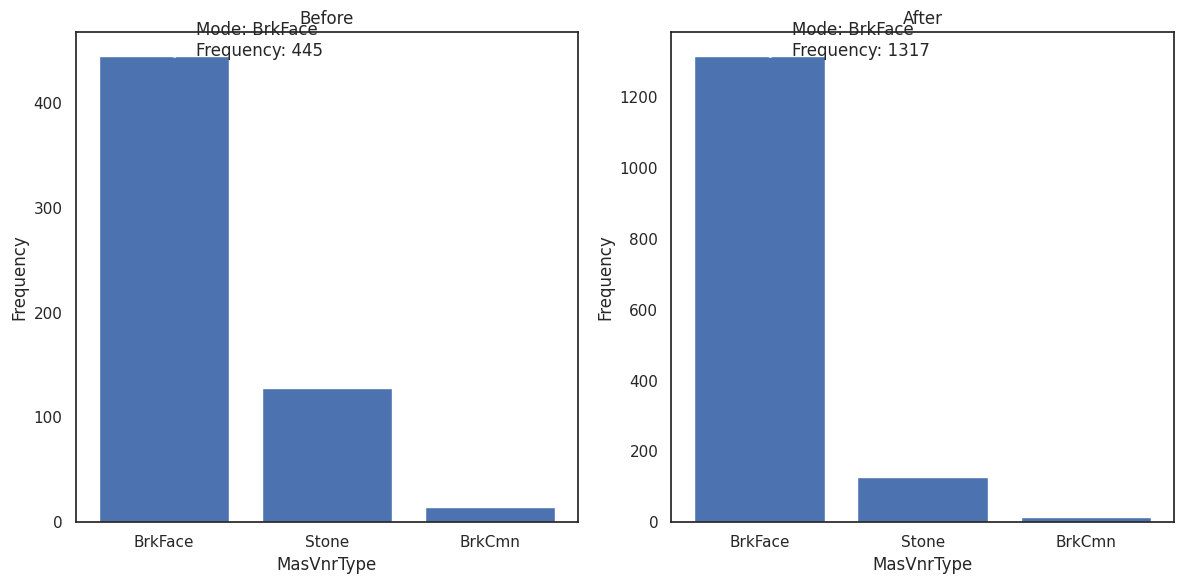

1070


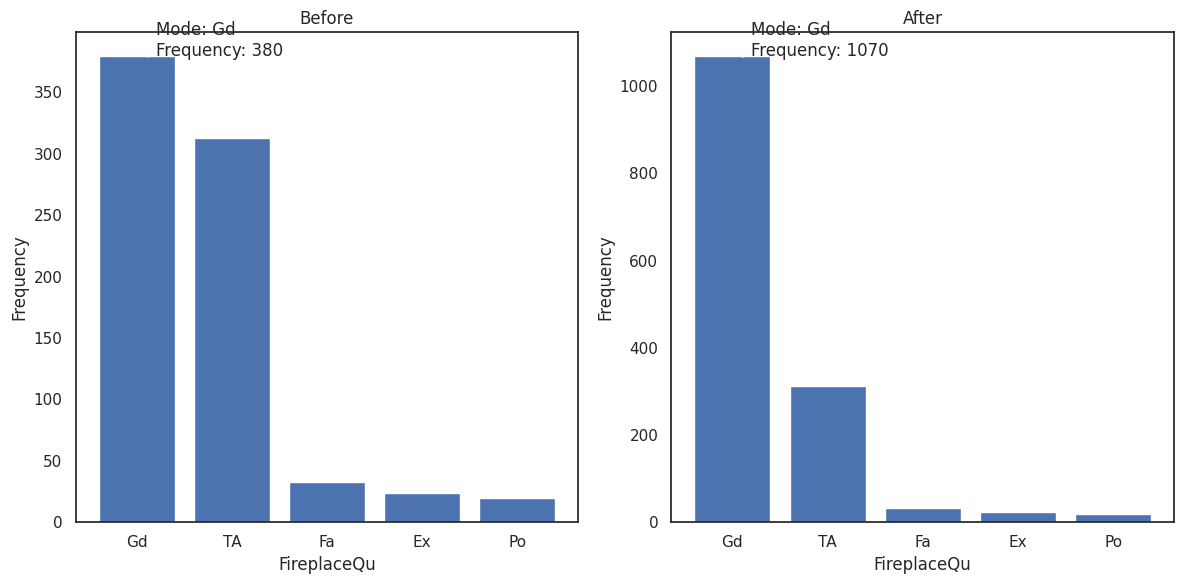

In [506]:
plot_mode_imputation(train_df, train_df_clone, 'MasVnrType')
plot_mode_imputation(train_df, train_df_clone, 'FireplaceQu')

Pros
  - For categorical data where mean or median cannot be calculated, mode is a good statistical measure for central tendency.
  - <b>BrkFace</b> and <b>Gd</b> are the most frequent feature sample in the data.
  - It is straightforward, it's also computationally inexpensive, making it feasible for large datasets.
    
Cons
  - Mode imputation might lead the data to have bias to most frequent feature value, which might lead data imbalance when we train the model.
  - It can hurt the variability of the data.
  - If the number of missing values is high, filling them all with the mode can disproportionately inflate the frequency of that category, leading to incorrect analysis or predictions.


Conclusion, I will choose to go with <b>Random Imputation</b> because the above reasons.

#### Random Imputation

In [507]:
def random_imputation(df, column):
    non_na_values = df[column].dropna().unique()
    na_positions = df.index[df[column].isna()].tolist()
    random_values = random.choices(non_na_values, k=len(na_positions))
    
    for pos, value in zip(na_positions, random_values):
        df.at[pos, column] = value
    return df
    

In [508]:
def plot_random_imputation(before_df, after_df, column):

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].bar(before_df[column].value_counts().index,
               before_df[column].value_counts().values,)
    axs[0].set_title('Before')
    axs[0].set_xlabel(column)
    axs[0].set_ylabel('Frequency')

    random_imputation(after_df, column)
    
    axs[1].bar(after_df[column].value_counts().index,
               after_df[column].value_counts().values)
    axs[1].set_title('After')
    axs[1].set_xlabel(column)
    axs[1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

In [511]:
train_df_clone = train_df.copy()

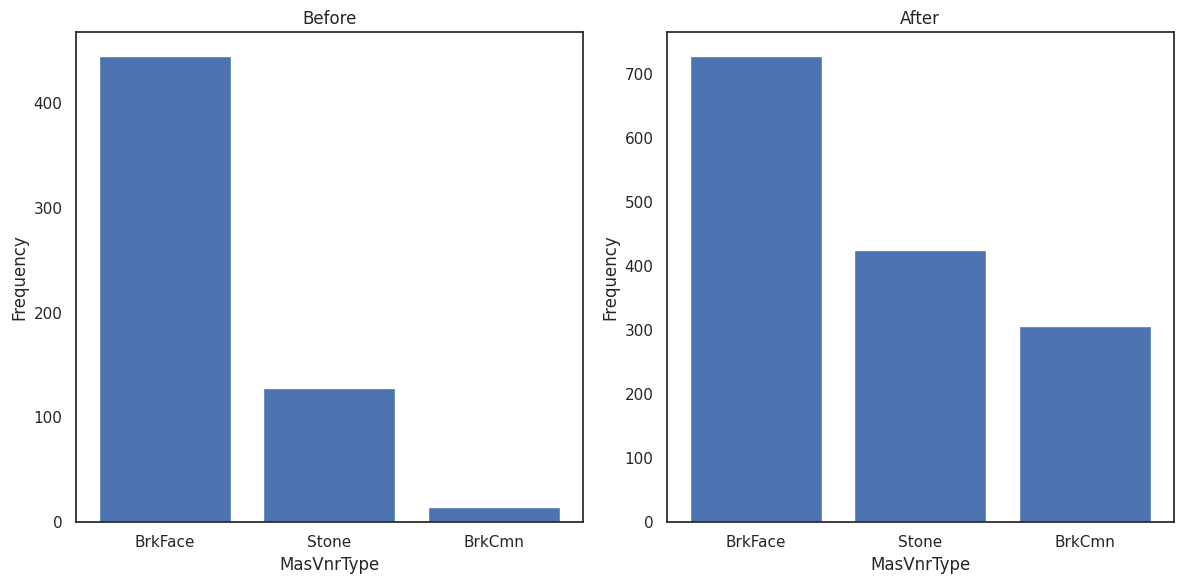

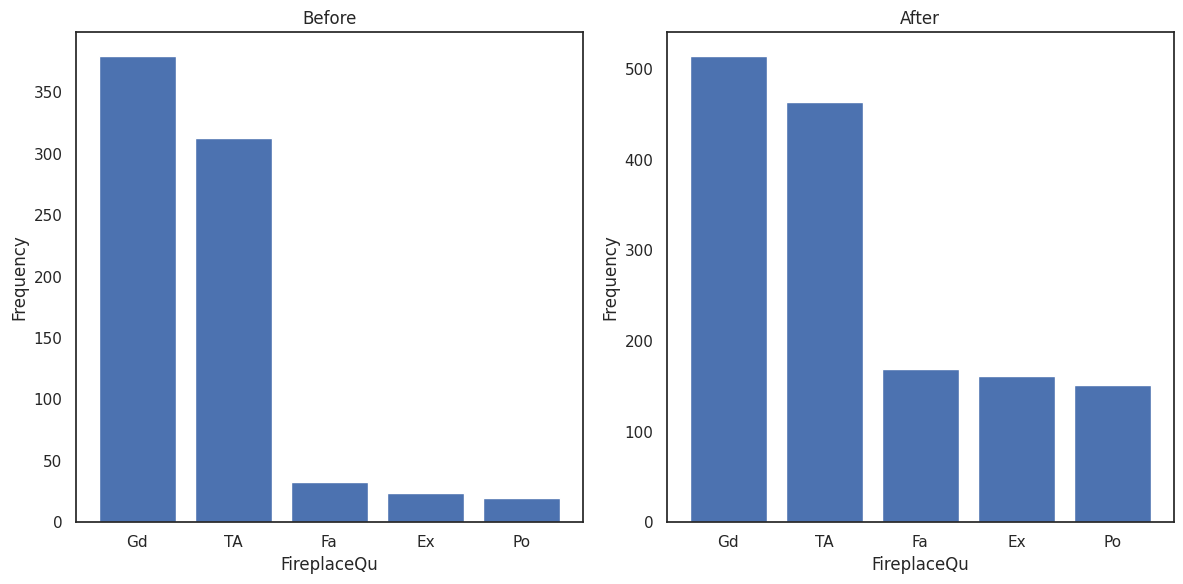

In [512]:
plot_random_imputation(train_df, train_df_clone, 'MasVnrType')
plot_random_imputation(train_df, train_df_clone, 'FireplaceQu')

- <b>Pros</b>
  - All unique samples will be randomly selected as a fair choice.
  - It can maintain the original distribution and variance of the dataset because it uses actual observed values for imputation.
- <b>Cons</b>
  - Because the imputation is random, this may add noise into the dataset, especially if the missing values are not completely at random.
  - The imputation is stochastic, leading to different results every time the imputation is carried out, which might not be desirable in all scenarios.
  

In [513]:
train_df = random_imputation(train_df, 'MasVnrType')
train_df = random_imputation(train_df, 'FireplaceQu')

In [514]:
missing_data = find_null_value(train_df)
missing_data.head(20)

,Total,Percent
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageCond,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479
BsmtFinType2,38,0.026027
BsmtExposure,38,0.026027
BsmtFinType1,37,0.025342
BsmtCond,37,0.025342


#### Median Imputation

I will use Median Imputation which is more robust to outliers.

In [515]:
train_df['LotFrontage'].fillna(train_df['LotFrontage'].median(), inplace=True)

#### Drop NA

In [516]:
train_df = train_df.dropna()

In [517]:
missing_data = find_null_value(train_df)
missing_data.head(20)

,Total,Percent
Id,0,0.0
HalfBath,0,0.0
FireplaceQu,0,0.0
Fireplaces,0,0.0
Functional,0,0.0
TotRmsAbvGrd,0,0.0
KitchenQual,0,0.0
KitchenAbvGr,0,0.0
BedroomAbvGr,0,0.0
FullBath,0,0.0


#### Drop `Id`

In [518]:
train_df = train_df.drop(columns = ['Id'], axis = 1)

In [519]:
print(f'Total number of missing data in the dataset {train_df.isnull().sum().max()}')

Total number of missing data in the dataset 0


# Exploratory Data Analysis (EDA)

### Target Data Distribution (Sale Price Data Distribution)

We will see its distribution and the outliers through the <b>graph</b> as well as from <b>Skewiness and Kurtosis</b>

count      1338.000000
mean     186761.782511
std       78913.847668
min       35311.000000
25%      135000.000000
50%      168500.000000
75%      220000.000000
max      755000.000000
Name: SalePrice, dtype: float64
 median sale price according to the dataset 168500.0


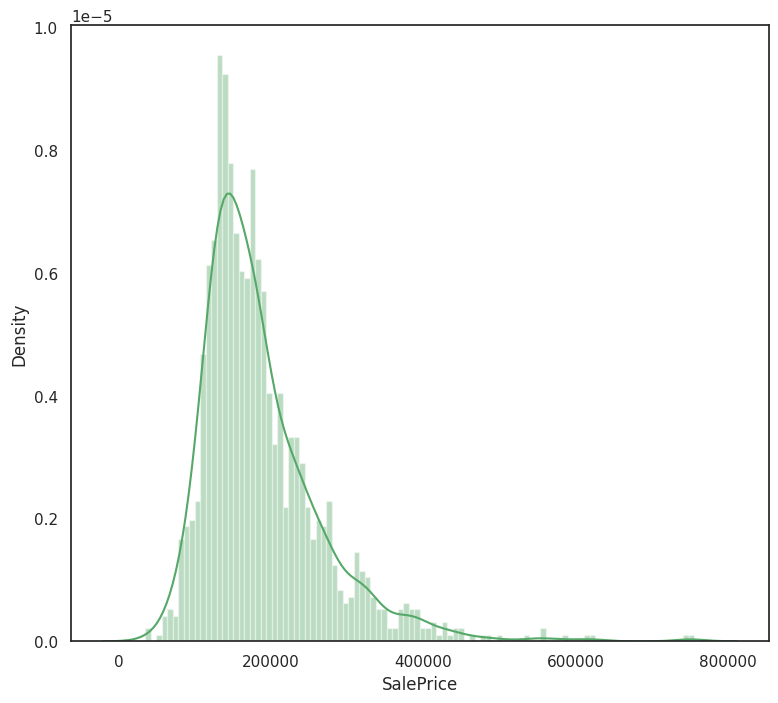

In [521]:
print(train_df.SalePrice.describe())
plt.figure(figsize=(9, 8))
sns.distplot(train_df.SalePrice, color='g', bins=100, hist_kws={'alpha': 0.4});

print(f' median sale price according to the dataset {np.median(train_df.SalePrice.values)}')

#### Skewiness and Kurtosis

In [522]:
print(f' Skewiness {np.round(skew(train_df.SalePrice), 2)}')
print(f' Kurtosis {np.round(kurtosis(train_df.SalePrice), 2)}')

 Skewiness 1.94
 Kurtosis 6.79


- Skewness of 1.94: The data distribution is significantly skewed to the right. It indicates that the tail on the right side of the distribution is long towards the lower end of the distribution.
- Kurtosis of 6.79: It indicates that the data distribution has heavier tails and a sharper peak than a normal distribution. There might be more extreme values in the dataset than a normally distributed dataset.

## Find Correlation

It is important to understand the correlation between features and target. It is unlikely to need all the features we have for the prediction the target value.

In [523]:
numerical_cols = train_df.select_dtypes(include = ['float', 'int64']).columns

### Variant Inflation Factor (VIF)

In [524]:
X = train_df[numerical_cols]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data.sort_values(by = 'VIF'))


          feature           VIF
33        MiscVal  1.034466e+00
30      3SsnPorch  1.041128e+00
32       PoolArea  1.121488e+00
31    ScreenPorch  1.210673e+00
17   BsmtHalfBath  1.235575e+00
29  EnclosedPorch  1.446397e+00
28    OpenPorchSF  1.901133e+00
7      MasVnrArea  1.930214e+00
27     WoodDeckSF  1.958869e+00
2         LotArea  2.626542e+00
23     Fireplaces  3.148739e+00
19       HalfBath  3.689704e+00
16   BsmtFullBath  3.855628e+00
0      MSSubClass  4.861169e+00
34         MoSold  6.704515e+00
1     LotFrontage  1.763438e+01
18       FullBath  2.871363e+01
26     GarageArea  3.421433e+01
36      SalePrice  3.452003e+01
20   BedroomAbvGr  3.471463e+01
25     GarageCars  4.113357e+01
4     OverallCond  4.726799e+01
21   KitchenAbvGr  5.313573e+01
3     OverallQual  8.347544e+01
22   TotRmsAbvGrd  8.528044e+01
6    YearRemodAdd  2.474417e+04
5       YearBuilt  2.700007e+04
35         YrSold  2.734012e+04
24    GarageYrBlt  2.870470e+04
13       2ndFlrSF           inf
11    To

The last 8 features with "inf" VIF are near perfectly collinear with each other. For example, `TotalBsmtSF` might be the sum of `BsmtFinSF1`, `BsmtFinSF2`, and `BsmtUnfSF`, leading to perfect collinearity. So, we need to remove one some of them to break collinearlity. We will drop some similiar columns to reduce collinearlity.

In [525]:
train_df = train_df.drop(columns = ['2ndFlrSF', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', 'BsmtFinSF1', 'GarageYrBlt', 'YrSold', 'YearRemodAdd'], axis = 1)

In [526]:
X = train_df.select_dtypes(include = ['float', 'int64'])
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data.sort_values(by = 'VIF'))

          feature         VIF
26        MiscVal    1.028216
23      3SsnPorch    1.038339
8    LowQualFinSF    1.083549
25       PoolArea    1.111718
11   BsmtHalfBath    1.145886
24    ScreenPorch    1.180588
22  EnclosedPorch    1.278575
6      MasVnrArea    1.873677
21    OpenPorchSF    1.883200
20     WoodDeckSF    1.929193
10   BsmtFullBath    2.286867
2         LotArea    2.581617
13       HalfBath    2.912953
17     Fireplaces    2.956167
0      MSSubClass    4.758017
27         MoSold    6.698663
1     LotFrontage   17.349513
7     TotalBsmtSF   23.104223
12       FullBath   23.299146
19     GarageArea   31.193014
4     OverallCond   32.654841
28      SalePrice   32.980410
14   BedroomAbvGr   33.041393
18     GarageCars   40.016892
15   KitchenAbvGr   50.211861
9       GrLivArea   67.231348
3     OverallQual   78.184658
16   TotRmsAbvGrd   84.253237
5       YearBuilt  147.374043


### Correlation Matrix

SalePrice        1.000000
OverallQual      0.783546
GrLivArea        0.711706
GarageCars       0.640154
GarageArea       0.607535
TotalBsmtSF      0.602042
FullBath         0.569313
TotRmsAbvGrd     0.551821
YearBuilt        0.504297
MasVnrArea       0.465811
Fireplaces       0.445434
LotFrontage      0.327835
OpenPorchSF      0.322786
WoodDeckSF       0.305983
HalfBath         0.258175
LotArea          0.254757
BsmtFullBath     0.209695
BedroomAbvGr     0.169266
ScreenPorch      0.096624
PoolArea         0.091881
3SsnPorch        0.042159
MoSold           0.041310
LowQualFinSF    -0.009992
MiscVal         -0.016990
BsmtHalfBath    -0.030175
MSSubClass      -0.079599
OverallCond     -0.108627
KitchenAbvGr    -0.111408
EnclosedPorch   -0.127385
Name: SalePrice, dtype: float64


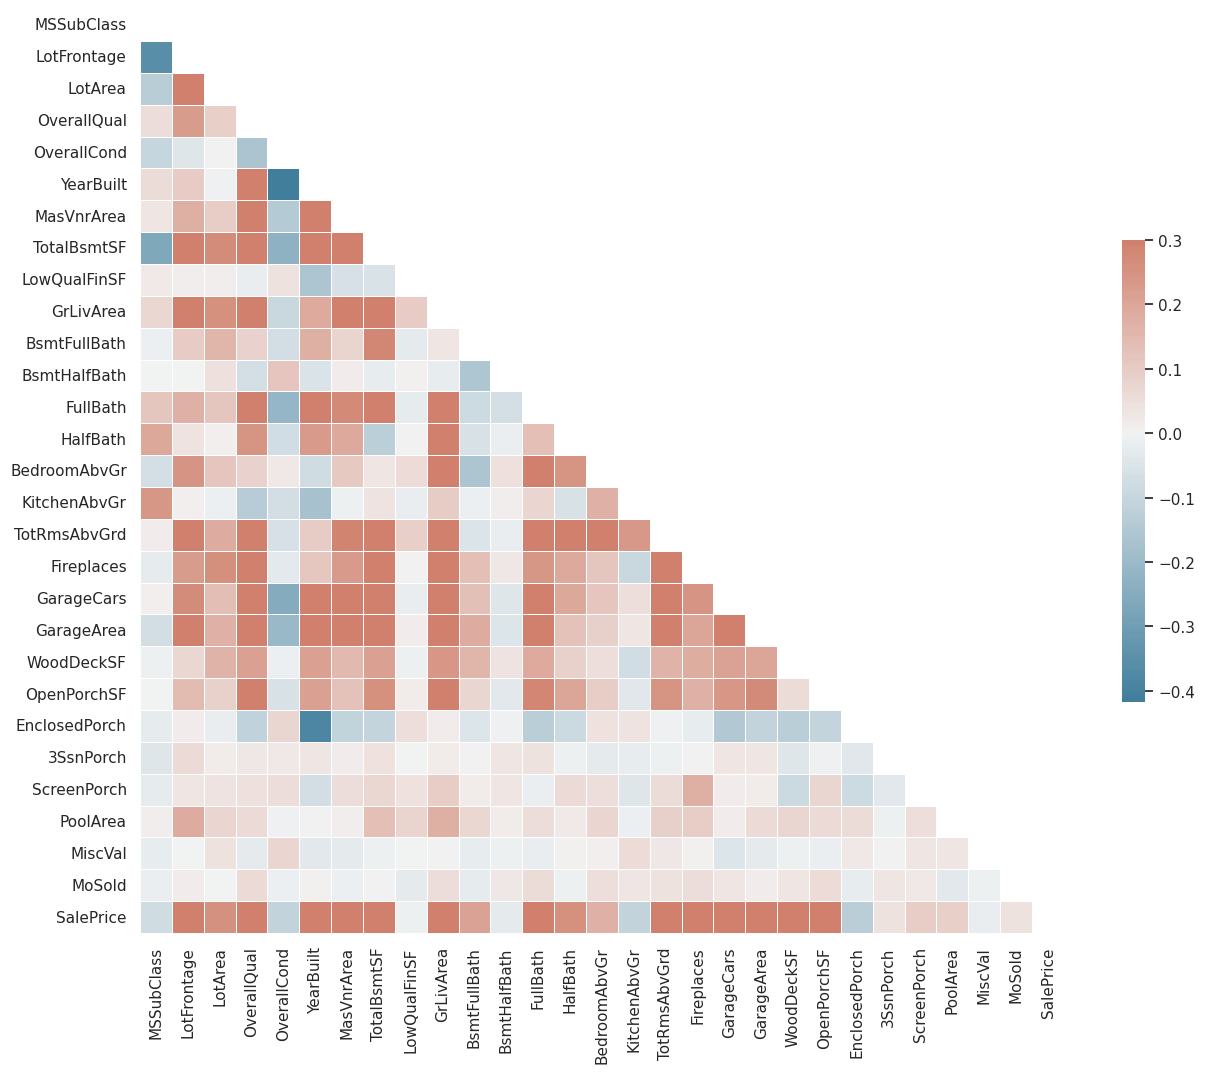

In [527]:
correlation_matrix = train_df.select_dtypes(include = ['float', 'int64']).corr()
print(correlation_matrix['SalePrice'].sort_values(ascending=False))
correlation_matrix_plot(correlation_matrix)

We can see that there are some features like `OverallQual`, `GrLivArea`, `GarageCars`, `GarageArea`, `TotalBsmtSF` has strong positive correlation with SalePrice.

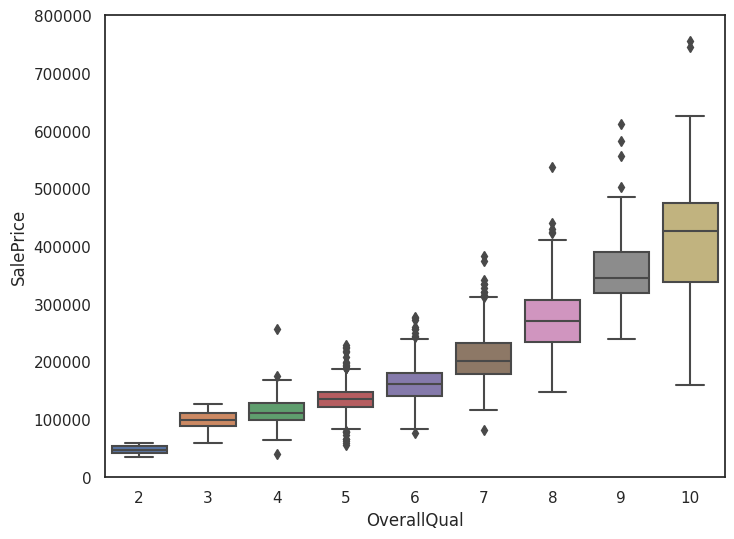

In [528]:
var = 'OverallQual'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

OverallQual and SalePrice seem to have linear correlation. It seems that higher quality demands higher prices.

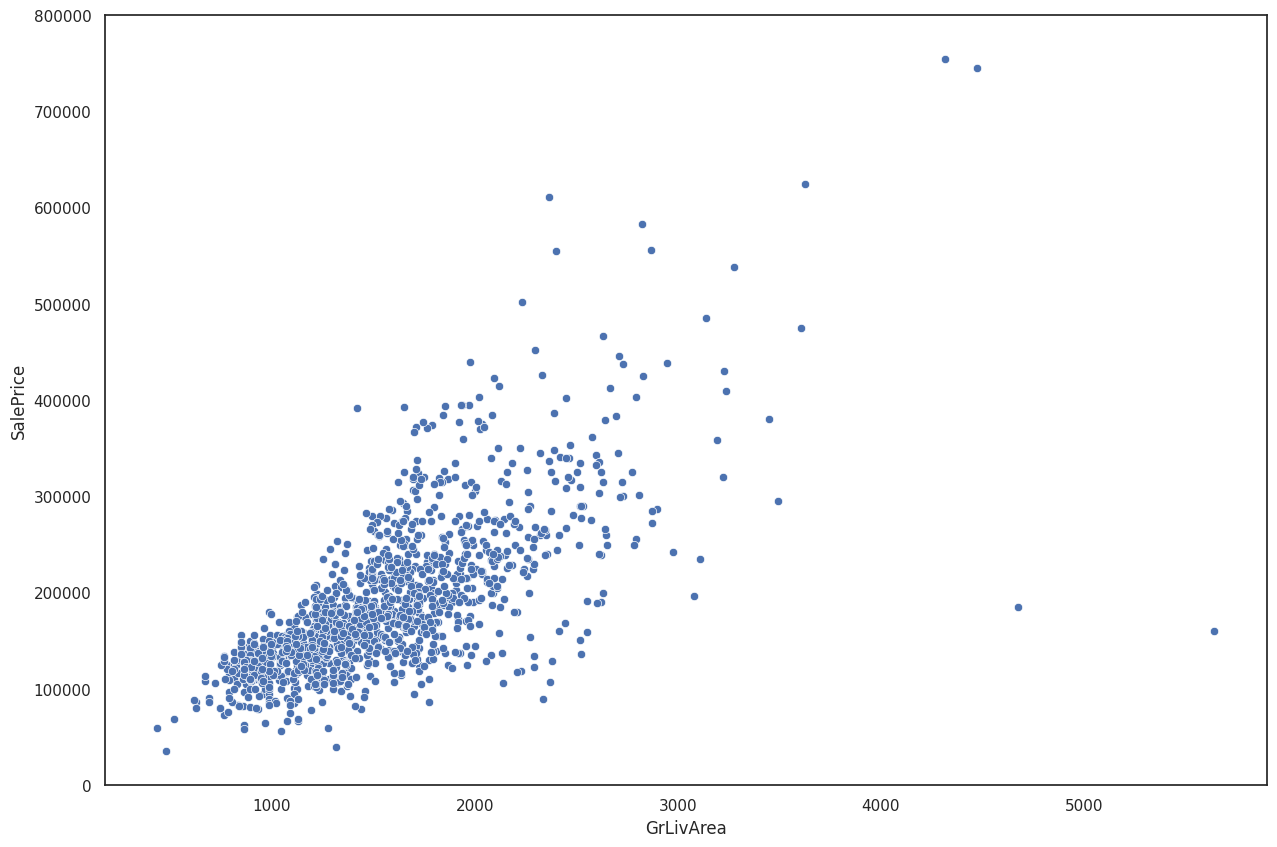

In [529]:
var = 'GrLivArea'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(15, 10))
fig = sns.scatterplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

GrLivArea and SalePrice seem to have linear relationship but there are outliers at the bottom right. There are outliers which suggest largest GrLivArea with low prices. We can remove them.

In [530]:
train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<300000)].index)

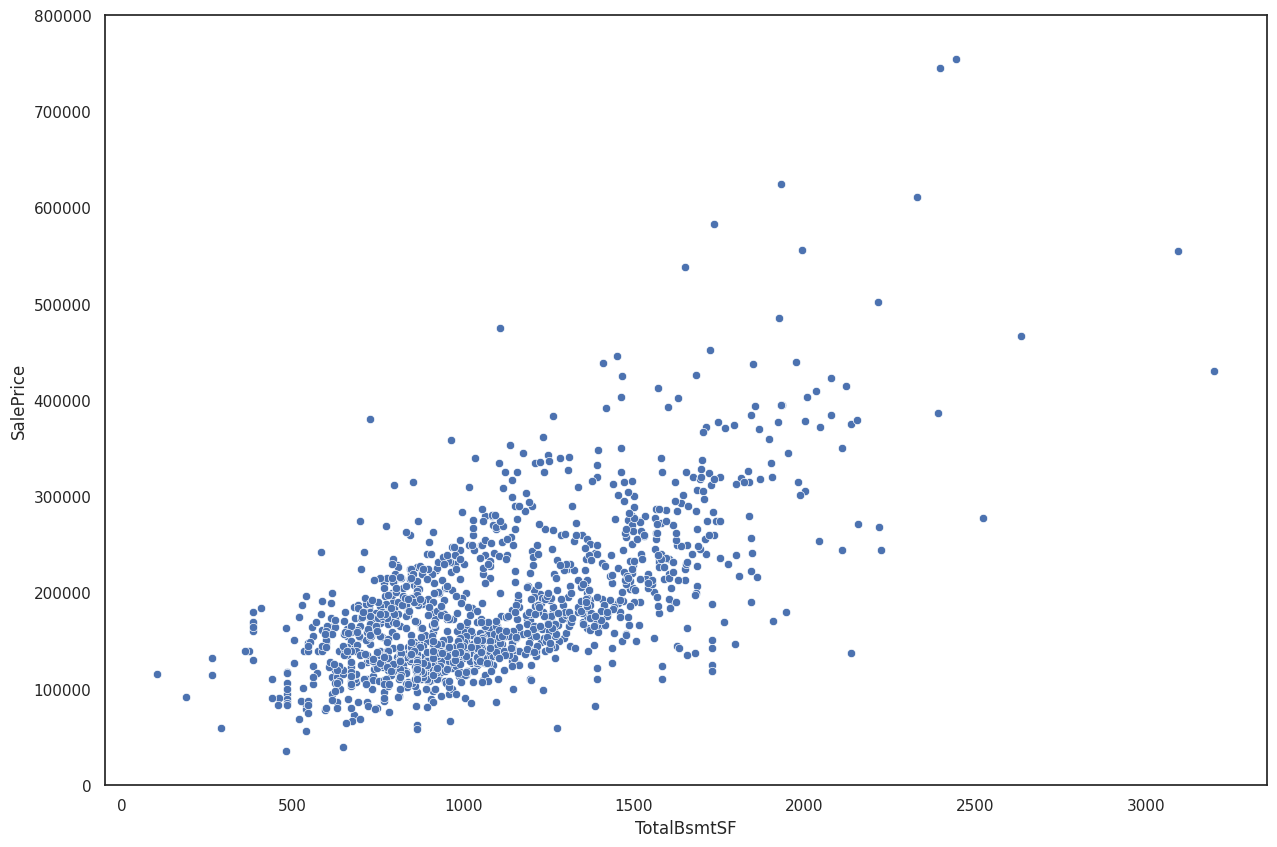

In [531]:
var = 'TotalBsmtSF'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(15, 10))
fig = sns.scatterplot(x = var, y = "SalePrice", data = data)
fig.axis(ymin = 0, ymax = 800000);

### Chi-squared test

I will use a statistical test, chi-squared tests to for categorial features.

In [532]:
def chi2_test(df):
    X = df[df.select_dtypes(include = ['object']).columns]
    
    chi2_data = pd.DataFrame()
    chi2_data["feature"] = X.columns
    chi2s = []
    pvalues = []
    for col in X.columns:
        # For categorical feature
        chi2, p_value, _, _ = stats.chi2_contingency(pd.crosstab(df[col], df['SalePrice']))
        
        chi2s.append(chi2)
        pvalues.append(p_value)
        
    chi2_data['chi2'] = chi2s
    chi2_data['p_value'] = pvalues
    return chi2_data

In [533]:
chi2data = chi2_test(train_df)
print(chi2data.sort_values(by = 'p_value'))

          feature          chi2       p_value
17      ExterQual   2811.486875  1.294357e-42
37       SaleType   6386.934740  1.067397e-40
28     Electrical   3423.789697  4.270613e-34
21       BsmtCond   2653.607777  1.604465e-31
38  SaleCondition   4065.333763  6.030287e-30
1          Street   1088.427302  1.878083e-28
0        MSZoning   3276.414434  1.221275e-25
29    KitchenQual   2502.096429  3.361517e-22
20       BsmtQual   2496.248240  7.214869e-22
34     GarageQual   3031.992059  4.999571e-14
2        LotShape   2329.826900  2.219481e-13
33   GarageFinish   1548.351856  2.725970e-09
7    Neighborhood  15694.784597  4.342533e-07
22   BsmtExposure   2162.762636  7.021146e-07
27     CentralAir    779.355259  1.020573e-05
19     Foundation   2662.532706  3.994538e-03
32     GarageType   3225.220808  4.418462e-02
5       LotConfig   2584.013322  5.716175e-02
14    Exterior1st   8173.908469  1.350918e-01
16     MasVnrType   1285.856431  1.579424e-01
25        Heating   1883.884503  3

I will remove the features which has p_value is closer to 1 because which is unlikely to have relation with the target variable.

In [534]:
cols_to_remove = chi2_data[chi2_data['p_value'] > 0.65]['feature']

In [535]:
print(f'These are the features which have p_value closer to 1 {cols_to_remove.values}')

These are the features which have p_value closer to 1 ['Utilities' 'LandSlope' 'Condition1' 'Condition2' 'BldgType' 'RoofStyle'
 'RoofMatl' 'Exterior2nd' 'ExterCond' 'BsmtFinType1' 'BsmtFinType2'
 'HeatingQC' 'Functional' 'GarageCond' 'PavedDrive']


In [536]:
train_df = train_df.drop(columns = cols_to_remove, axis = 1)

In [537]:
train_df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'Exterior1st', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'TotalBsmtSF', 'Heating', 'CentralAir', 'Electrical',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'SaleType', 'SaleCondition', 'SalePrice'],
      dtype='object')

In [538]:
chi2data = chi2_test(train_df)
print(chi2data.sort_values(by = 'p_value'))

          feature          chi2       p_value
9       ExterQual   2811.486875  1.294357e-42
22       SaleType   6386.934740  1.067397e-40
16     Electrical   3423.789697  4.270613e-34
12       BsmtCond   2653.607777  1.604465e-31
23  SaleCondition   4065.333763  6.030287e-30
1          Street   1088.427302  1.878083e-28
0        MSZoning   3276.414434  1.221275e-25
17    KitchenQual   2502.096429  3.361517e-22
11       BsmtQual   2496.248240  7.214869e-22
21     GarageQual   3031.992059  4.999571e-14
2        LotShape   2329.826900  2.219481e-13
20   GarageFinish   1548.351856  2.725970e-09
5    Neighborhood  15694.784597  4.342533e-07
13   BsmtExposure   2162.762636  7.021146e-07
15     CentralAir    779.355259  1.020573e-05
10     Foundation   2662.532706  3.994538e-03
19     GarageType   3225.220808  4.418462e-02
4       LotConfig   2584.013322  5.716175e-02
7     Exterior1st   8173.908469  1.350918e-01
8      MasVnrType   1285.856431  1.579424e-01
14        Heating   1883.884503  3

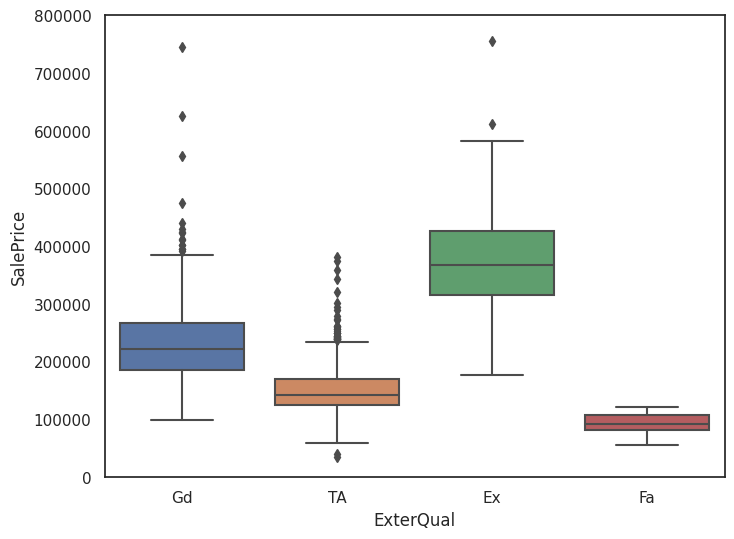

In [539]:
var = 'ExterQual'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

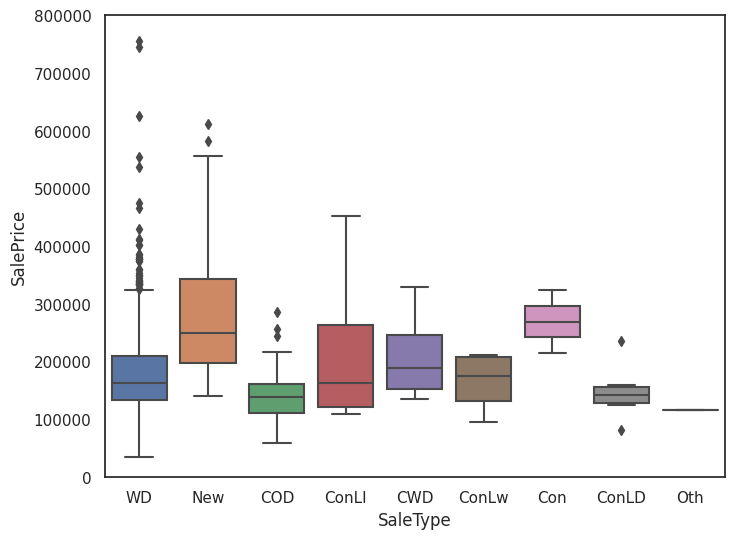

In [540]:
var = 'SaleType'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

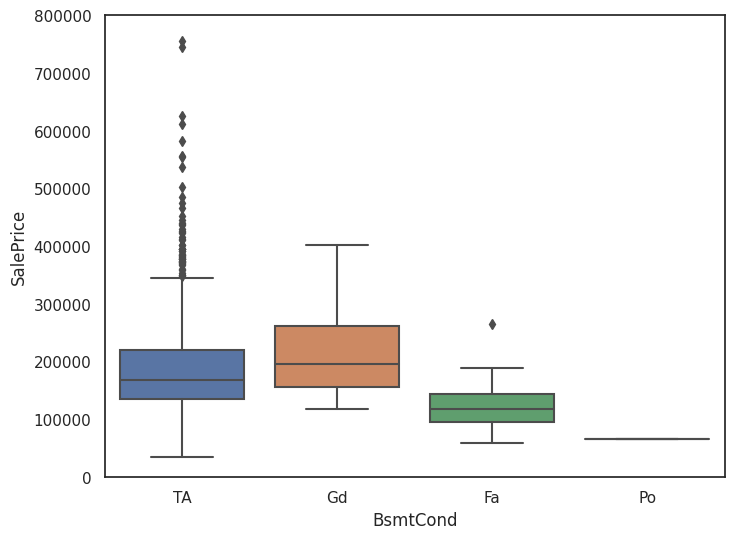

In [541]:
var = 'BsmtCond'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

In [542]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,Neighborhood,HouseStyle,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,Inside,CollgCr,2Story,...,61,0,0,0,0,0,2,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,FR2,Veenker,1Story,...,0,0,0,0,0,0,5,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,Inside,CollgCr,2Story,...,42,0,0,0,0,0,9,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,Corner,Crawfor,2Story,...,35,272,0,0,0,0,2,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,FR2,NoRidge,2Story,...,84,0,0,0,0,0,12,WD,Normal,250000


#### EDA Summary 

- We have analyse the data using Correlation Matrix, Variance Inflation Factor (VIF) and statistical test, Chi-squared test to remove features which might not helpful for modelling.
- Now, we have left with 53 features.

# Modelling

### Model Choices
- #### XGBoost
  - XGBoost is an optimized gradient boosting library designed for speed and performance, often used for supervised learning tasks. 

- #### CatBoost
  - CatBoost is a gradient boosting library that excels in handling categorical features and aims for ease of use with robust, out-of-the-box performance.

### Evaluation Metrics
We will use the following metric
- <b>RMSE (Root Mean Squared Error)</b> is a measure of the average magnitude of the model's errors, treating all errors equally, regardless of their direction or size.

### Experiments
My experiments are the following:
1. Train XGBoost
2. Hyperparameter Tuning (XGBoost)
3. Train CatBoost
4. Hyperparameter Tuning (CatBoost)

### Feature Engineering

#### Label Encoding

I will transform the categorical into numerical format using label encoding.

In [543]:
train_cate_df = train_df.copy()

In [544]:
cate_cols = train_cate_df.select_dtypes(include = ['object']).columns
for c in cate_cols:
    lbl = LabelEncoder() 
    lbl.fit(list(train_cate_df[c].values)) 
    train_cate_df[c] = lbl.transform(list(train_cate_df[c].values))

print('Shape all_data: {}'.format(train_cate_df.shape))

Shape all_data: (1336, 53)


In [545]:
train_cate_df[cate_cols].head()

,MSZoning,Street,LotShape,LandContour,LotConfig,Neighborhood,HouseStyle,Exterior1st,MasVnrType,ExterQual,...,Heating,CentralAir,Electrical,KitchenQual,FireplaceQu,GarageType,GarageFinish,GarageQual,SaleType,SaleCondition
0,3,1,3,3,4,5,5,11,1,2,...,0,1,4,2,1,1,1,4,8,4
1,3,1,3,3,2,24,2,7,1,3,...,0,1,4,3,4,1,1,4,8,4
2,3,1,0,3,4,5,5,11,1,2,...,0,1,4,2,4,1,1,4,8,4
3,3,1,0,3,0,6,5,12,2,3,...,0,1,4,2,2,5,2,4,8,0
4,3,1,0,3,2,15,5,11,1,2,...,0,1,4,2,4,1,1,4,8,4


In [546]:
train_df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'Exterior1st', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'TotalBsmtSF', 'Heating', 'CentralAir', 'Electrical',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'SaleType', 'SaleCondition', 'SalePrice'],
      dtype='object')

In [611]:
train_all = train_cate_df.copy()

### Evaluation Metrics

Two helper functions to evaluate the performace using Cross Validation RMSLE and RMSE.

In [455]:
def rmsle_cv(model, xtrain, ytrain, n_folds):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(xtrain.values)
    rmse= np.sqrt(-cross_val_score(model, xtrain.values, ytrain, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

def rmse(y, y_pred):
    return np.round(np.sqrt(mean_squared_error(y, y_pred)), 2)

## Model Training

### XGBoost

#### Data Preparation

In [612]:
train_all["SalePrice"] = np.log1p(train_all["SalePrice"])
train_all = pd.get_dummies(train_all)

X = train_all.drop(columns = ['SalePrice'], axis = 1)
y = train_all['SalePrice']

In [613]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [614]:
print(f' Training Features {X_train.shape}')
print(f' Training Target {y_train.shape}')
print(f' Test Feature {X_test.shape}')
print(f' Test Target {y_test.shape}')


 Training Features (1068, 52)
 Training Target (1068,)
 Test Feature (268, 52)
 Test Target (268,)


#### Train 

In [615]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [620]:
n_folds = 5

score = rmsle_cv(model_xgb, X_train, y_train, n_folds)
print("XGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

XGBoost score: 0.1213 (0.0177)



In [621]:
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.4603, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0468, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1.7817, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2200, n_jobs=None, nthread=-1,
             num_parallel_tree=None, ...)

In [616]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {'objective': 'reg:squarederror', 'eval_metric': 'rmse'}

evals = [(dtrain, 'train'), (dtest, 'eval')]
evals_result = {}
bst = xgb.train(params, dtrain, num_boost_round=100, evals=evals, evals_result=evals_result)


[0]	train-rmse:0.28336	eval-rmse:0.29853
[1]	train-rmse:0.21821	eval-rmse:0.24315
[2]	train-rmse:0.17152	eval-rmse:0.20865
[3]	train-rmse:0.13899	eval-rmse:0.18680
[4]	train-rmse:0.11514	eval-rmse:0.17384
[5]	train-rmse:0.09780	eval-rmse:0.16528
[6]	train-rmse:0.08468	eval-rmse:0.16199
[7]	train-rmse:0.07520	eval-rmse:0.15914
[8]	train-rmse:0.06801	eval-rmse:0.15688
[9]	train-rmse:0.06178	eval-rmse:0.15393
[10]	train-rmse:0.05669	eval-rmse:0.15242
[11]	train-rmse:0.05350	eval-rmse:0.15214
[12]	train-rmse:0.05091	eval-rmse:0.15095
[13]	train-rmse:0.04834	eval-rmse:0.15036
[14]	train-rmse:0.04550	eval-rmse:0.14948
[15]	train-rmse:0.04392	eval-rmse:0.14954
[16]	train-rmse:0.04261	eval-rmse:0.14870
[17]	train-rmse:0.04212	eval-rmse:0.14831
[18]	train-rmse:0.04142	eval-rmse:0.14815
[19]	train-rmse:0.04037	eval-rmse:0.14808
[20]	train-rmse:0.03930	eval-rmse:0.14843
[21]	train-rmse:0.03749	eval-rmse:0.14857
[22]	train-rmse:0.03668	eval-rmse:0.14845
[23]	train-rmse:0.03546	eval-rmse:0.14855
[2

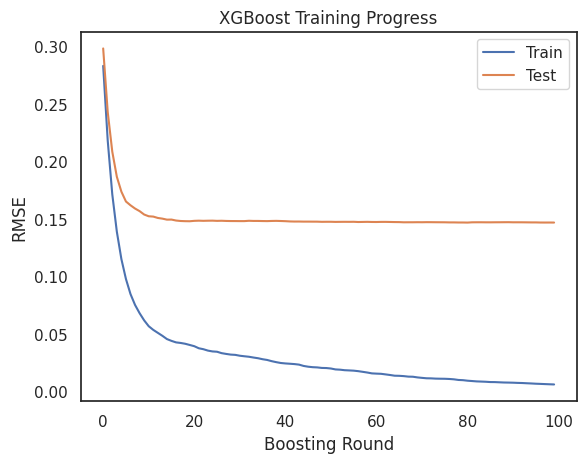

In [617]:
plt.plot(evals_result['train']['rmse'], label='Train')
plt.plot(evals_result['eval']['rmse'], label='Test')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('XGBoost Training Progress')
plt.legend()
plt.show()

#### Evaluate

In [8]:
xgb_train_pred = model_xgb.predict(X_train)
print(f'XGBoost Train RMSE {rmse(y_train, xgb_train_pred)}')

xgb_pred = model_xgb.predict(X_test)
print(f'XGBoost Test RMSE {rmse(y_test, xgb_pred)}')


XGBoost Train RMSE 0.09
XGBoost Test RMSE 0.12


### XGBoost with Hyperparameter Tuning

In [624]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

xgb_model = xgb.XGBRegressor()

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.8, 0.9]})

In [625]:
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_parameters}")
print(f"Best Score: {best_score}")
best_model = grid_search.best_estimator_

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}
Best Score: 0.9012268726566676


In [626]:
best_xgb_model = xgb.XGBRegressor(**best_parameters)
best_xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [3]:
xgb_train_pred = best_xgb_model.predict(X_train)
print(f'XGBoost Train RMSE {rmse(y_train, xgb_train_pred)}')

xgb_pred = best_xgb_model.predict(X_test)
print(f'XGBoost Test RMSE {rmse(y_test, xgb_pred)}')

XGBoost Train RMSE 0.06
XGBoost Test RMSE 0.13


### CatBoost

#### Data Preparation

In [549]:
train_clone = train_df.copy()
float_cols = train_clone.select_dtypes(include = ['float64']).columns
train_clone[float_cols] = train_clone[float_cols].astype(int)

In [559]:
train_clone["SalePrice"] = np.log1p(train_clone["SalePrice"])
train_clone = pd.get_dummies(train_clone)

X  = train_clone.drop(columns = ['SalePrice'], axis = 1)
y = train_clone['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

categorical_features_names = list(X.columns)

In [561]:
train_pool = Pool(X_train, 
                  label=y_train,
                  cat_features=categorical_features_names)
test_pool = Pool(X_test, 
                  label=y_test,
                  cat_features=categorical_features_names)

#### Train

In [563]:
model = CatBoostRegressor(custom_metric= ['R2', 'RMSE'], learning_rate=0.01, depth = 10, n_estimators=5000)
model.fit(train_pool, eval_set=test_pool, verbose=1000, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0416175	test: 0.0417206	best: 0.0417206 (0)	total: 18.2ms	remaining: 1m 30s
1000:	learn: 0.0112569	test: 0.0232236	best: 0.0232236 (1000)	total: 16.6s	remaining: 1m 6s
2000:	learn: 0.0070376	test: 0.0228457	best: 0.0228457 (2000)	total: 35.6s	remaining: 53.3s
3000:	learn: 0.0046750	test: 0.0227822	best: 0.0227815 (2955)	total: 53.8s	remaining: 35.8s
4000:	learn: 0.0029821	test: 0.0227638	best: 0.0227635 (3998)	total: 1m 12s	remaining: 18.1s
4999:	learn: 0.0020532	test: 0.0227434	best: 0.0227428 (4873)	total: 1m 31s	remaining: 0us

bestTest = 0.02274284214
bestIteration = 4873

Shrink model to first 4874 iterations.


#### Evaluate

In [4]:
cat_train_pred = model.predict(X_train)
print(f'CatBoost Train RMSE {rmse(y_train, xgb_train_pred)}')

cat_pred = model.predict(X_test)
print(f'CatBoost Test RMSE {rmse(y_test, xgb_pred)}')


CatBoost Train RMSE 9.53
CatBoost Test RMSE 9.57


### CatBoost with Hyperparameter Tuning

In [593]:
param_grid = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

In [594]:
grid_search = GridSearchCV(estimator=CatBoostRegressor(),
                           param_grid=param_grid,
                           cv=5,  
                           n_jobs=-1,
                           verbose=0)
grid_search.fit(X_train, y_train, verbose=0)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f6cd1f3b710>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8], 'iterations': [500, 1000],
                         'l2_leaf_reg': [1, 3, 5, 7, 9],
                         'learning_rate': [0.01, 0.1, 0.2]})

In [595]:
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_parameters}")
print(f"Best Score: {best_score}")

Best Parameters: {'depth': 4, 'iterations': 500, 'l2_leaf_reg': 5, 'learning_rate': 0.1}
Best Score: 0.8861827658601926


In [596]:
best_model = CatBoostRegressor(**best_parameters)
best_model.fit(X_train, y_train)

0:	learn: 0.3532770	total: 702us	remaining: 350ms
1:	learn: 0.3335623	total: 1.18ms	remaining: 295ms
2:	learn: 0.3157700	total: 1.61ms	remaining: 268ms
3:	learn: 0.2988716	total: 2.08ms	remaining: 257ms
4:	learn: 0.2846018	total: 2.57ms	remaining: 255ms
5:	learn: 0.2707849	total: 3.08ms	remaining: 253ms
6:	learn: 0.2595443	total: 3.63ms	remaining: 256ms
7:	learn: 0.2493907	total: 4.32ms	remaining: 266ms
8:	learn: 0.2391028	total: 5ms	remaining: 273ms
9:	learn: 0.2283552	total: 5.7ms	remaining: 279ms
10:	learn: 0.2197443	total: 6.38ms	remaining: 284ms
11:	learn: 0.2123077	total: 7.06ms	remaining: 287ms
12:	learn: 0.2046252	total: 7.72ms	remaining: 289ms
13:	learn: 0.1984473	total: 8.38ms	remaining: 291ms
14:	learn: 0.1922836	total: 9.03ms	remaining: 292ms
15:	learn: 0.1870114	total: 9.67ms	remaining: 293ms
16:	learn: 0.1821393	total: 10.3ms	remaining: 293ms
17:	learn: 0.1774804	total: 11ms	remaining: 294ms
18:	learn: 0.1737408	total: 11.6ms	remaining: 295ms
19:	learn: 0.1708838	total: 1

In [7]:
cat_train_pred = best_model.predict(X_train)
print(f'CatBoost Train RMSE {rmse(y_train, xgb_train_pred)}')

cat_pred = best_model.predict(X_test)
print(f'CatBoost Test RMSE {rmse(y_test, xgb_pred)}')


CatBoost Train RMSE 0.04
CatBoost Test RMSE 0.12


# Result Analysis

#### Performance Comparison

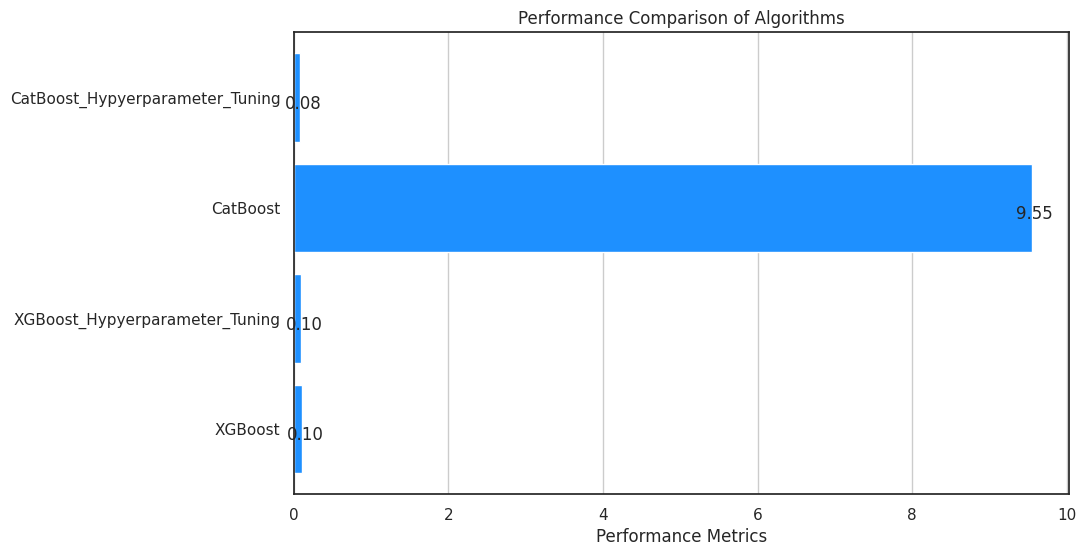

In [637]:
result = {
    'XGBoost': [0.09, 0.12],
    'XGBoost_Hypyerparameter_Tuning': [0.06,0.13],
    'CatBoost': [9.53, 9.57],
    'CatBoost_Hypyerparameter_Tuning': [0.04,0.12],
}

labels = list(result.keys())
values = [np.mean(v) for v in result.values()]

plt.figure(figsize=(10, 6))
bars = plt.barh(labels, values, color='dodgerblue')

for bar in bars:
    plt.text(bar.get_width() - 0.2, bar.get_y() + bar.get_height()/2 - 0.1, f"{bar.get_width():.2f}")

plt.xlabel('Performance Metrics')
plt.title('Performance Comparison of Algorithms')
plt.grid(axis='x')

plt.show()


I have run experiments on XGBoost and CatBoost which both have strong benefits in both categorical and numerical data. 
- Without Hyperparameter Tuning,
  - XGBoost achieves training RMSE 0.09 and testing RMSE 0.12. The model can be improved with better hyperparameters.
  - CatBoost achieves training RMSE 9.53 and testing RMSE 9.57, which is relatively higher than XGBoost. The model is underfitting.
- With Hyperparameter Tuning,
  - XGBoost has slightly lower training RMSE 0.06 but testing RMSE 0.13. The model is overfit and doesn't seem to generalize on the training data. It might have been memorizing it.
  - CatBoost achieves significantly higher performance than the one without tuning. CatBoost training RMSE 0.04 and testing RMSE 0.12.

#### Let's compare the prediction and ground truth.

In [642]:
predictions = best_model.predict(X_test)
predictions = np.expm1(predictions)

In [644]:
y_test_reversed =  np.expm1(y_test)

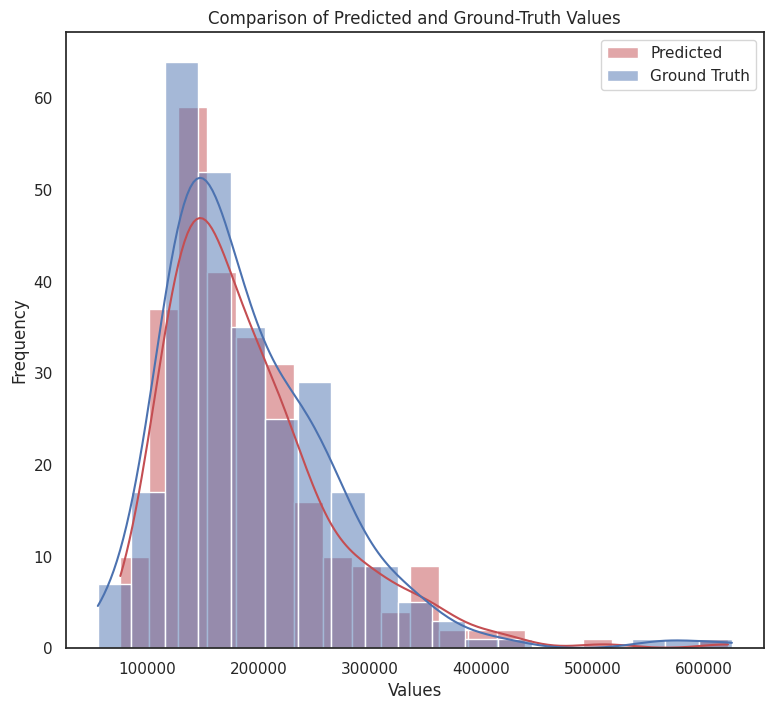

In [650]:
plt.figure(figsize=(9, 8))
sns.histplot(predictions, kde=True, label='Predicted', color='r')
sns.histplot(y_test_reversed, kde=True, label='Ground Truth', color='b')

plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Comparison of Predicted and Ground-Truth Values')
plt.legend()

# Show the plot
plt.show()


The plot shows that the trend of prediction is similar to the ground truth.

# Conclusion and Further Work

In the future, I want to use K-nearest neighbors to replace missing values so that we do not need to drop many data points. I will perform more hyperparameter tuning. I also want to explore with different supervised learning algorithms. I want see the performance of simple l